In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
output_path = "./final_ppt_images_train"

In [3]:
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)

In [4]:
len(image_elements)

152

In [5]:
len(image_elements[0])

127144

In [6]:
import os
import ollama
from tqdm import tqdm
import base64
from PIL import Image
from io import BytesIO
from langchain.text_splitter import CharacterTextSplitter


In [8]:
img_summaries = []

# Iterate over all image strings in the list with a tqdm progress bar
for image_string in tqdm(image_elements, desc="Processing images"):
    # Decode the image string using utf-8 encoders
    img_data = base64.b64decode(image_string)
    img = Image.open(BytesIO(img_data))
    
    # Convert the image to RGB
    img_rgb = img.convert('RGB')
    
    # Save the image to a temporary file
    img_rgb.save("temp.jpg")
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'I am going to provide an image related to the medical field, specifically multiple sclerosis. The image could be a graph, chart, or any other form of visual representation. Please extract the text labels from the image, understand the image deeply, and provide a detailed description of the image in medical terms.',
                'images':["temp.jpg"]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

print(img_summaries)
documents = []
retrieve_contents = []
for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
vectorstore.save_local("ppt_images_MS_final")


from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter_rec = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 0,
    length_function = len,
    is_separator_regex=False
)
texts_rec = text_splitter_rec.split_documents(documents)
rec_vectorstore = FAISS.from_documents(documents=texts_rec, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
rec_vectorstore.save_local("rec_ppt_images_MS_final")


text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000, chunk_overlap=100)

doc_splits = text_splitter.split_documents(documents)
char_vectorstore = FAISS.from_documents(documents=doc_splits, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))
char_vectorstore.save_local("char_ppt_images_MS_final")


Processing images: 100%|██████████| 152/152 [2:57:03<00:00, 69.89s/it]   


[' The image you\'ve provided appears to be a graph or chart related to medical studies, specifically those involving multiple sclerosis (MS). Here is the text from the image:\n\n- "OPERAND I AND OPERAND II"\n- "TWO DISTINCT STUDIES EVALUATING THE EFFECTIVITY AND SAFETY OF CREZIUMB IN RMS"\n- "Double blind dummy treatment period"\n- "FOLLOWING 24 WEEKS"\n- "98% of patients treated with CREZIUMB"\n- "36% of patients treated with a PLACEBO"\n\nThe chart itself shows two vertical lines, each divided into horizontal sections. On the left side, there are three horizontal bars, each labeled with the percentage of patients from 0% to 100%, indicating the frequency of different outcomes for those on the study drug, Creziumb. The right side has a single horizontal bar at 36%, representing the percentage of patients who experienced an outcome that is not specified in the image.\n\nBelow the chart, there are two additional lines of text:\n\n- "FOLLOWING 24 WEEKS"\n- "98% of patients treated with 

In [2]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')

In [14]:
db = FAISS.load_local("4_ex_rec_ppt_images_MS_final", embeddings,allow_dangerous_deserialization=True)

In [15]:
prompt_template = """
Answer the following question only based on the provided context.
                    Think step by step before providing a detailed answer.Provide only the answer and don't be expressive.Please don't start your answer with 'based on the provided context'.Please don't start your answer with 'According to the text'.
                    understand the whole given context and then provide the appropriate answer for the question
                    <context>{context}</context>
                    Question:{question}
"""

In [16]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [6]:
db.similarity_search("what are the common symtoms of MS")

[Document(page_content='The image you\'ve shared is an infographic related to multiple sclerosis (MS). It outlines the symptoms of MS, categorized into "common" and "unusual" categories. Here\'s a detailed description in medical terms:\n\n**Common Symptoms:**\n1. Fatigue: The feeling of being tired or worn out. This is one of the most common symptoms and can affect day-to-day activities.\n2. Muscle stiffness and spasms: These can cause muscles to feel stiff and tight, which can lead to painful spasms.\n3. Numbness or paresthesia: A feeling of numbness or tingling in the skin, often on the hands and feet, due to nerve damage.\n4. Vision problems: MS can cause vision issues such as blurred vision, double vision (diplopia), or even temporary blindness in an eye.\n5. Pain: A significant symptom of MS that can range from mild discomfort to severe pain.\n6. Bladder and bowel symptoms: MS can cause problems with the bladder and bowel, such as frequency of urination or constipation.', metadata

In [17]:

def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

# ppt test

In [8]:
result, relevant_images = answer("What are the Patient driven factors that HCPs should consider before starting the treatment for MS")
print(result)

c:\Users\RAHUL\Desktop\chatbot_new\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 The patient-driven factors that healthcare professionals (HCPs) should consider before starting the treatment for Multiple Sclerosis (MS) include understanding the individual's disease severity, co-morbidities, age, and health literacy. These factors can help tailor treatment plans to better suit each patient's unique needs. For example, older patients may require different medications or monitoring due to age-related changes in their body, while patients with depression might need additional mental health support alongside their MS care.


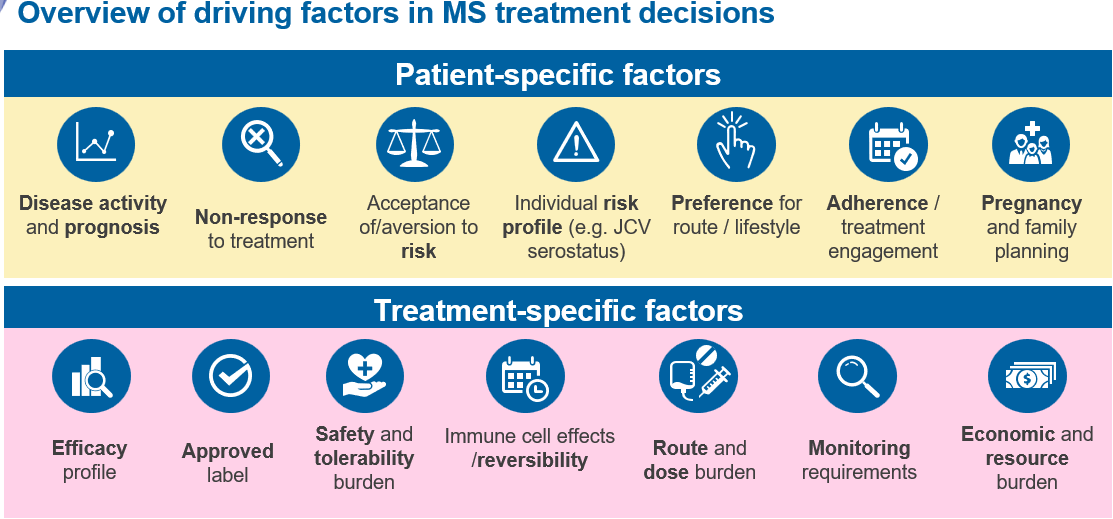

In [9]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [7]:
result, relevant_images = answer("What are the Patient driven factors that HCPs should consider before starting the treatment for MS")
print(result)

c:\Users\patel\Desktop\Final_Ms_chatbot\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Understanding the individual's disease severity, co-morbidities, age, and health literacy are patient-driven factors that healthcare professionals (HCPs) should consider before starting treatment for Multiple Sclerosis (MS). An older patient may require different medications or monitoring due to age-related changes in their body. A patient with depression might need additional mental health support alongside their MS care.


In [10]:
result, relevant_images = answer("what are the approaches in management of MS")
print(result)

 The approaches in management of MS include high efficacy approach, which is a DMFs-based treatment with chronic immunosuppressive drugs for controlling MS progression over an extended period, and linked to chronic relapsing remitting MS. The other approach is a comprehensive or holistic approach that considers patient-specific factors such as disease severity, co-morbidities, age, and health literacy, and treatment-specific factors like adherence, accessibility, affordability, and monitoring for adverse events.


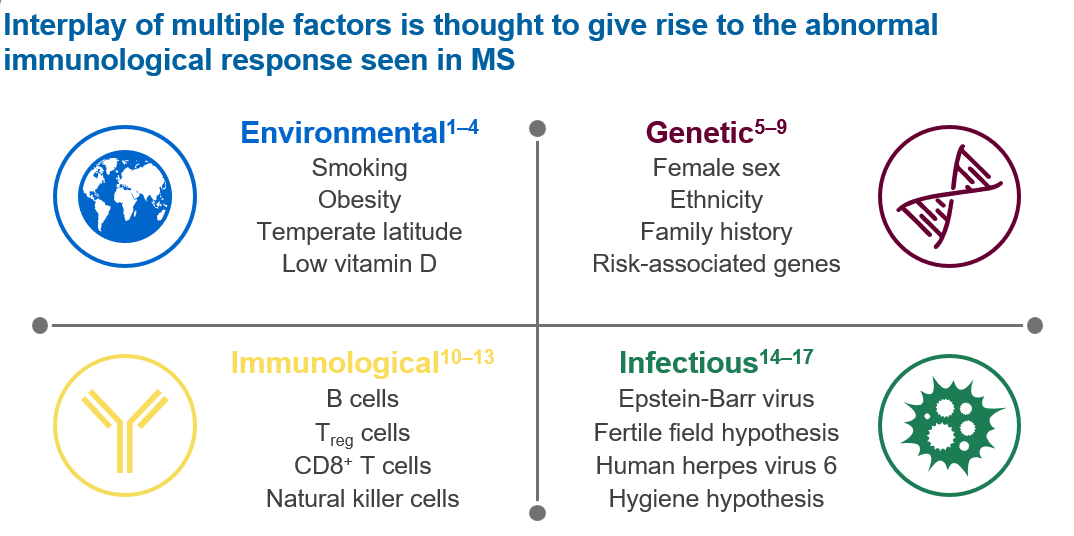

In [11]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [21]:
result, relevant_images = answer("what are the approaches in management of MS")
print(result)

 The approaches in management of MS include a high efficacy approach using DMFs-based treatment with chronic immunosuppressive drugs, and a symptomatic approach focusing on managing symptoms as they arise.


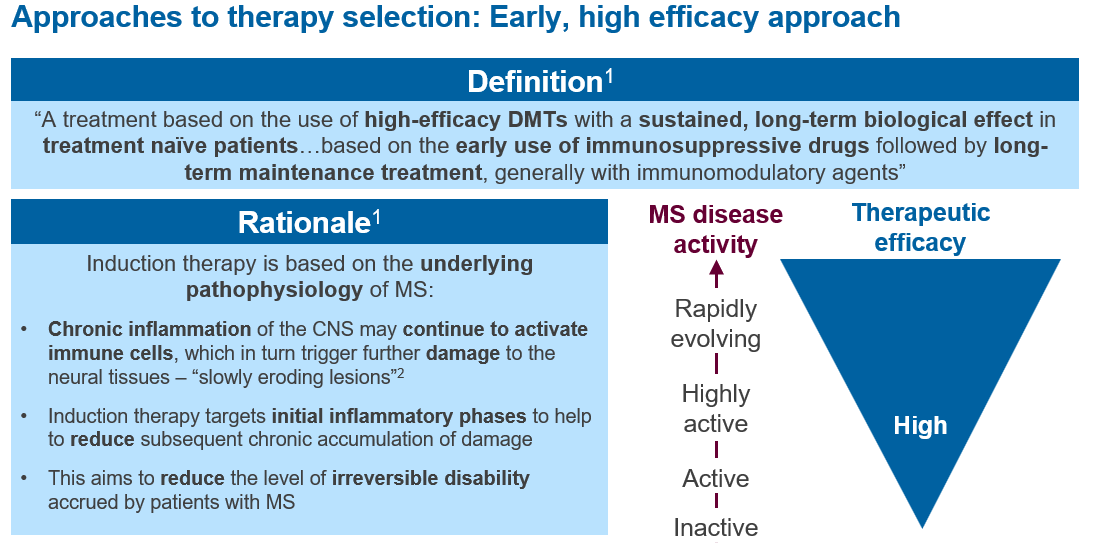

In [22]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [10]:
result, relevant_images = answer("Recently I was diagnosed with Relapsing-onset MS and the indicated MS phenotype is Highly active. List the name of the drugs which can be used to treat my condition")
print(result)

 Based on the context provided, the high efficacy approach for treating Relapsing-onset MS involves DMFs-based medications that are effective in controlling the progression of MS over an extended period. Some examples of these medications include:

1. Dimethyl fumarate (DMF)
2. Fingolimod
3. Natalizumab
4. Alemtuzumab
5. Mitoxantrone
6. Cladribine
7. Ocrelizumab
8. Rituximab

These medications are chronic immunosuppressive drugs that are used long term to manage MS in patients with a highly active phenotype. It's important to note that individual responses to these treatments may vary, and the most appropriate medication for any given patient should be determined through consultation with a healthcare professional.


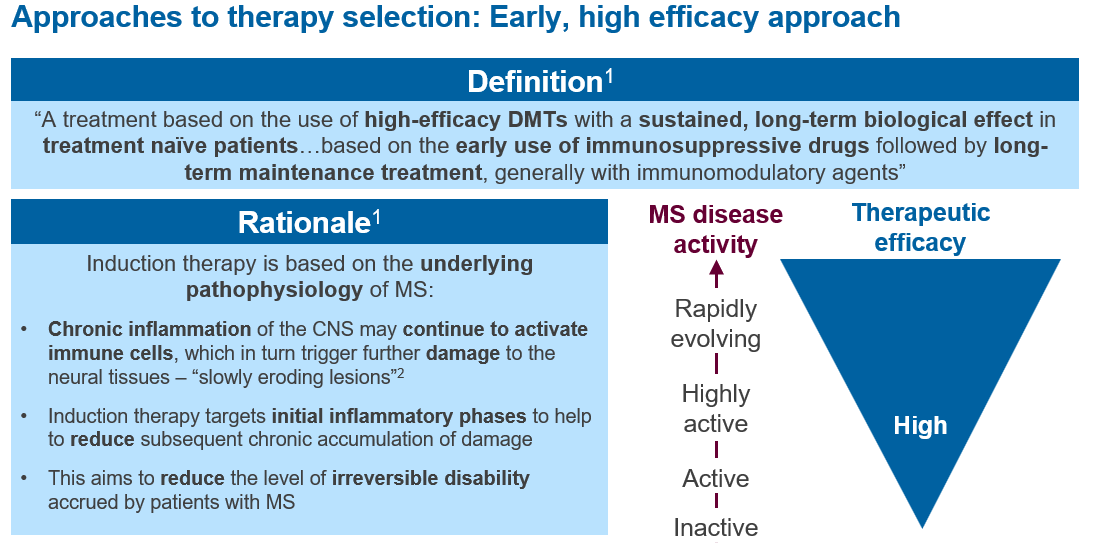

In [11]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [38]:
result, relevant_images = answer("RRMS is equally common in women and men right?")
print(result)

 Based on the context provided, RRMS has no difference in sex bias for both its incidence and prevalence. However, there is a higher incidence in females and a 50% higher risk in their first-degree relatives. Therefore, while RRMS may not be strictly more common in women than men, there are demographic factors that make it more likely to affect women.


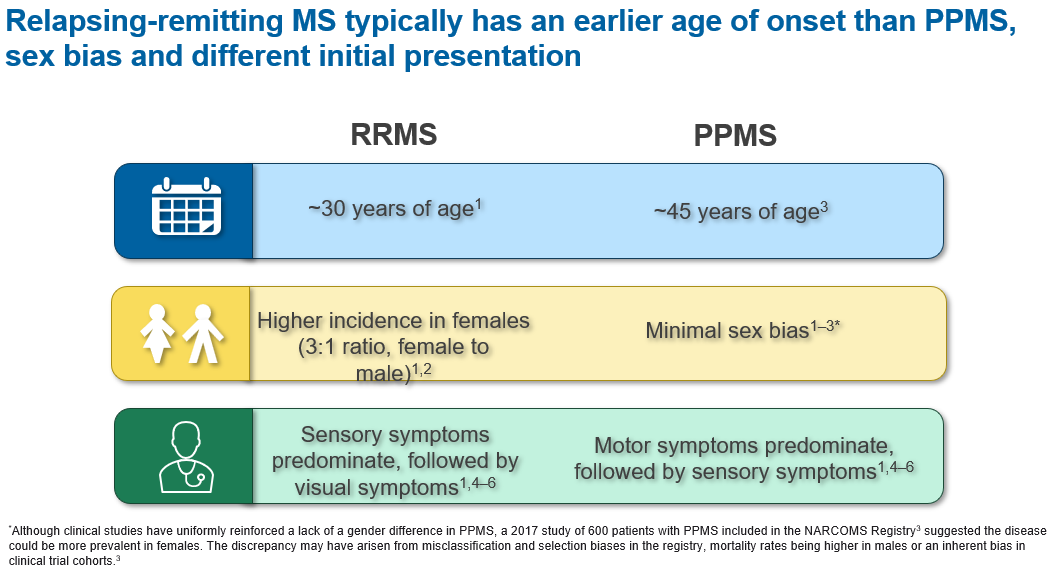

In [39]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [40]:
result, relevant_images = answer("What gives rise to the abnormal immunological response seen in MS?")
print(result)

 The exact cause of the abnormal immunological response in MS is not fully understood, but it's believed to involve a combination of genetic and environmental factors. The image context suggests that certain cytokines and B cells (specifically CD20 B cells) play important roles in this response. Abnormal levels or signaling of these components can contribute to the disease process in MS. Additionally, risk factors such as genetics, sex, and exposure to specific environmental triggers may also influence the development of MS.


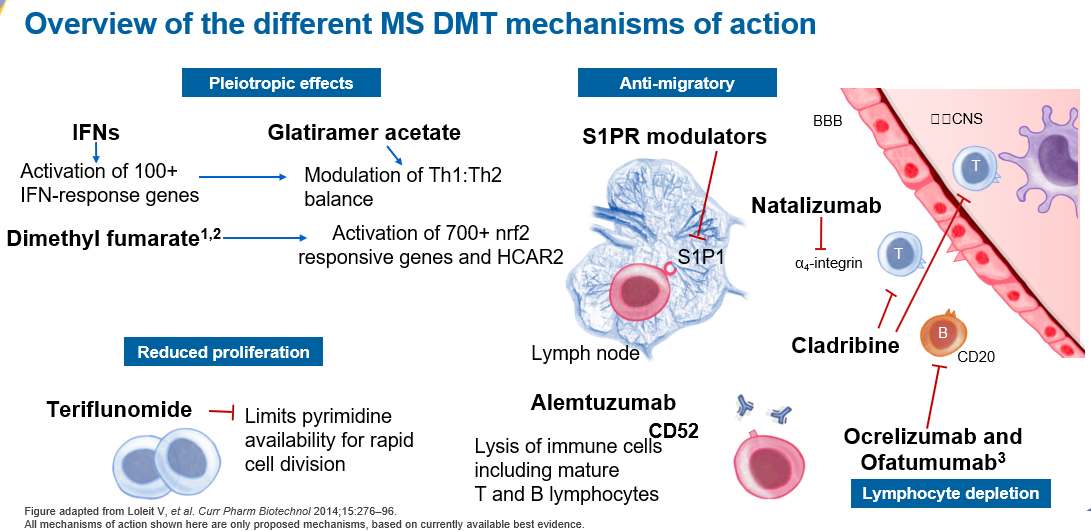

In [42]:
display.display(display.Image(base64.b64decode(relevant_images[1])))

In [43]:
result, relevant_images = answer("Recently I was diagnosed with MS and the doctor has prescribed Ocrevus for my condition. Is it safe for consumption?")
print(result)

 The context provided does not directly answer your question about the safety of Ocrevus for consumption, as it focuses on the decision-making process related to managing side effects and long-term outcomes of the medication. It mentions some safety concerns, such as the risk of infection, but it doesn't provide enough information to determine if these risks apply to individual patients or the overall safety of the medication.

It is important that you discuss any concerns or questions you have about your medication with your healthcare provider. They can provide you with accurate and up-to-date information based on your specific medical history and current condition.


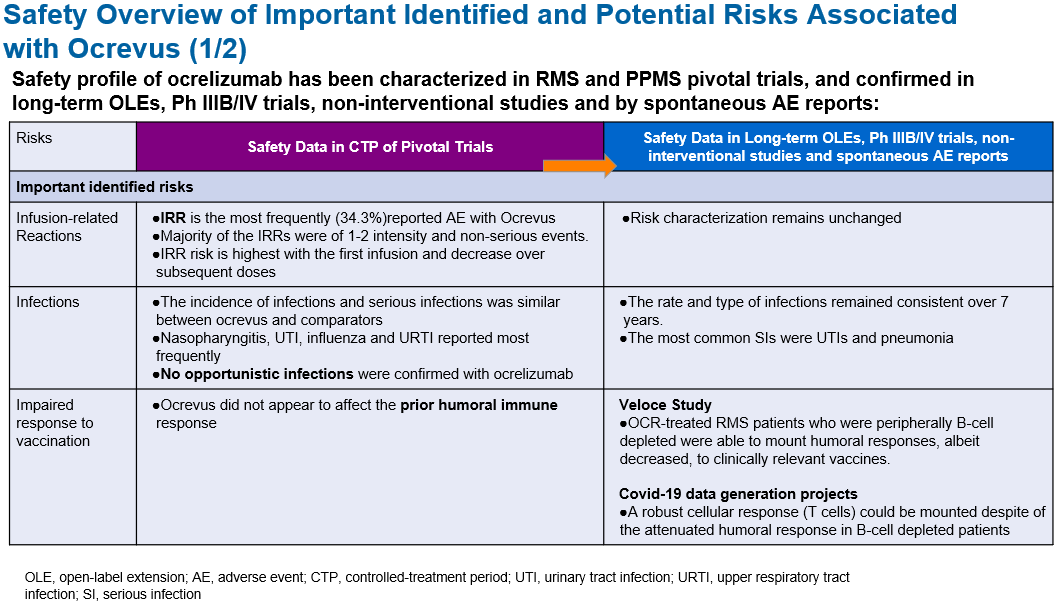

In [44]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [18]:
result, relevant_images = answer("What is the approved dose and treatment schedule for Ocrevus?")
print(result)

 The approved dose of Ocrevus is 7mg per dose, given once weekly.


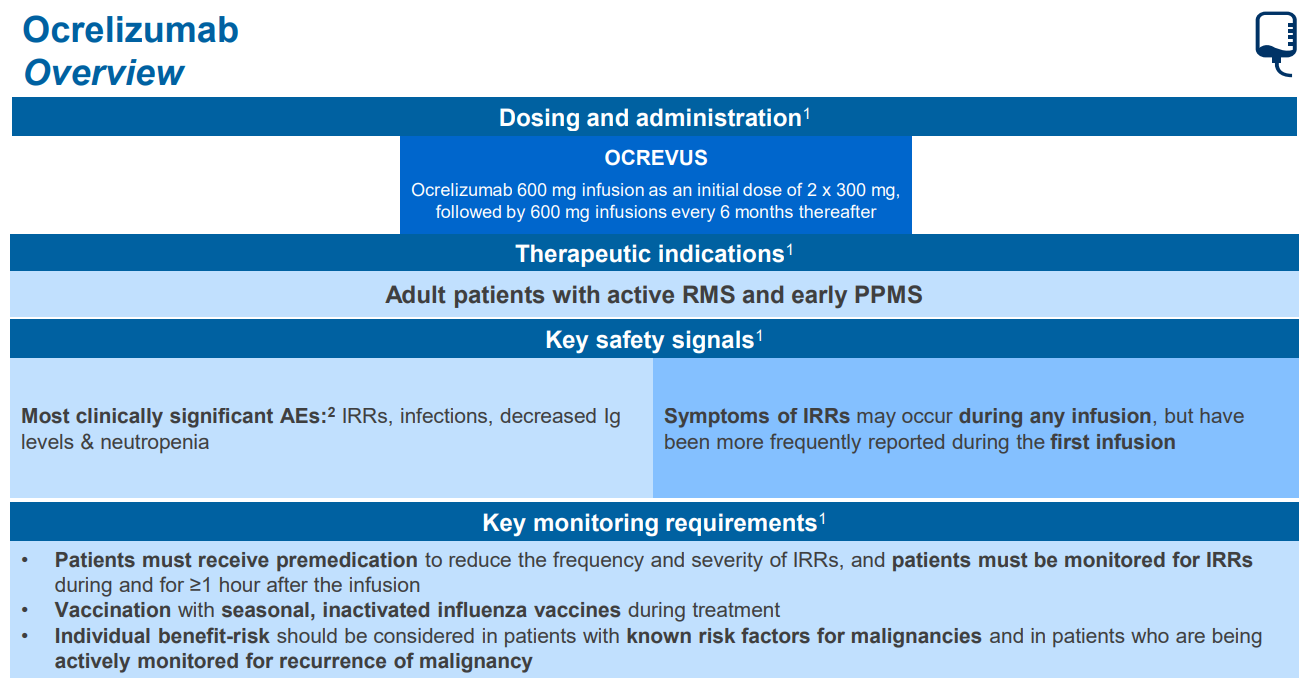

In [21]:
display.display(display.Image(base64.b64decode(relevant_images[2])))

In [47]:
result, relevant_images = answer("What must be given prior to ocrelizumab to reduce the frequency and severity of IRRs?")
print(result)

 Based on the context, there is no direct answer provided for what must be given prior to ocrelizumab to reduce the frequency and severity of IRRs. The text mentions that there are activities related to IRRs that can reduce the need for antibody inhibitors and potentially result in a 10% reduction in price, but it does not specify what those activities are or what should be given prior to administration of ocrelizumab.


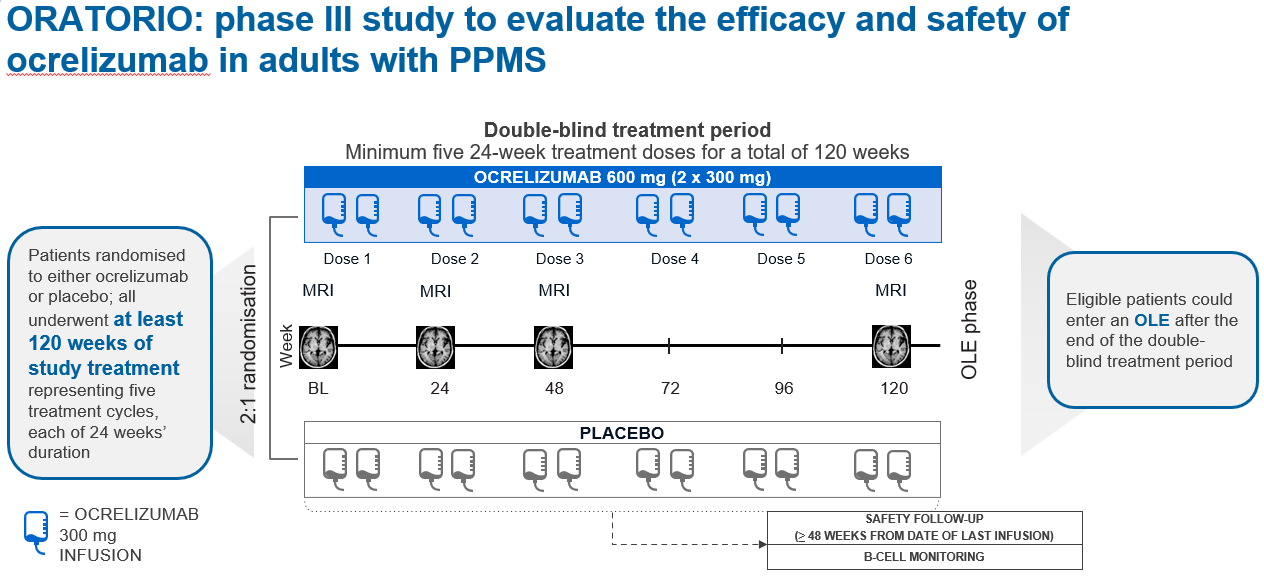

In [48]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [49]:
result, relevant_images = answer("What is recommended to be given to reduce the frequency and severity of IRRs?")
print(result)

 The image recommends reducing the incidence of severe and frequent reactions to infusional therapies to decrease the need for antibody inhibitors. However, the context does not provide specific information on what should be given to achieve this reduction.


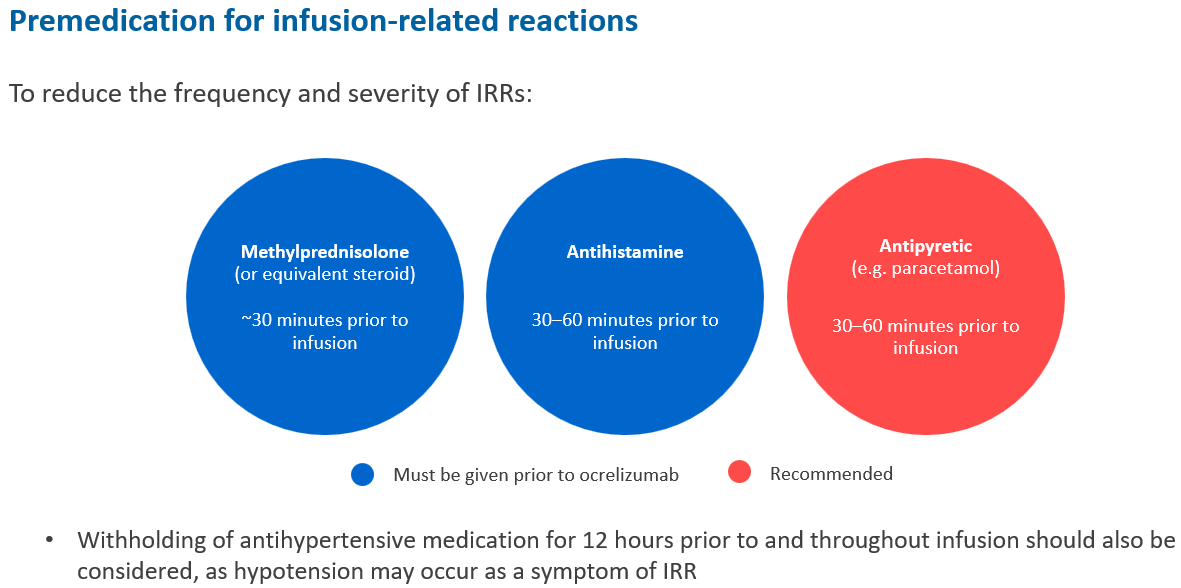

In [50]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [51]:
result, relevant_images = answer("Recently my doctor informed me that I’m severely immunocompromised. Can I be treated with Ocrevus?")
print(result)

 Based on the context provided, there are long-term safety concerns related to Ocrevus, specifically regarding infections, which may range from 20% to 35% across different studies or cohorts. Given your doctor's recent notification that you are severely immunocompromised, it would be important for both you and your healthcare provider to carefully consider the potential risks and benefits of initiating Ocrevus treatment in light of your current health status. It may be necessary to consult with a specialist or seek additional medical advice before making a decision.


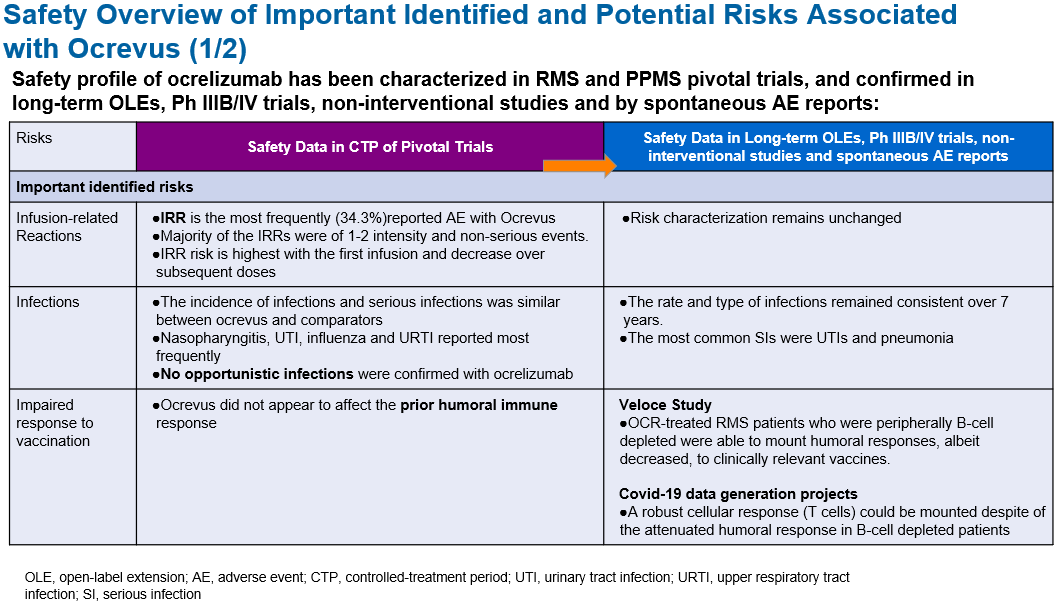

In [52]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [54]:
result, relevant_images = answer("What are the precautions for use of Ocrevus?")
print(result)

 The context does not provide specific information on precautions for the use of Ocrevus. However, it mentions several safety concerns related to Ocrevus, including long-term safety concerns regarding infections and interventions for managing side effects. It also mentions that data is not available for the use of Ocrevus in certain populations such as pregnant women, children, and patients with hepatic impunity or later stages of renal impairment.


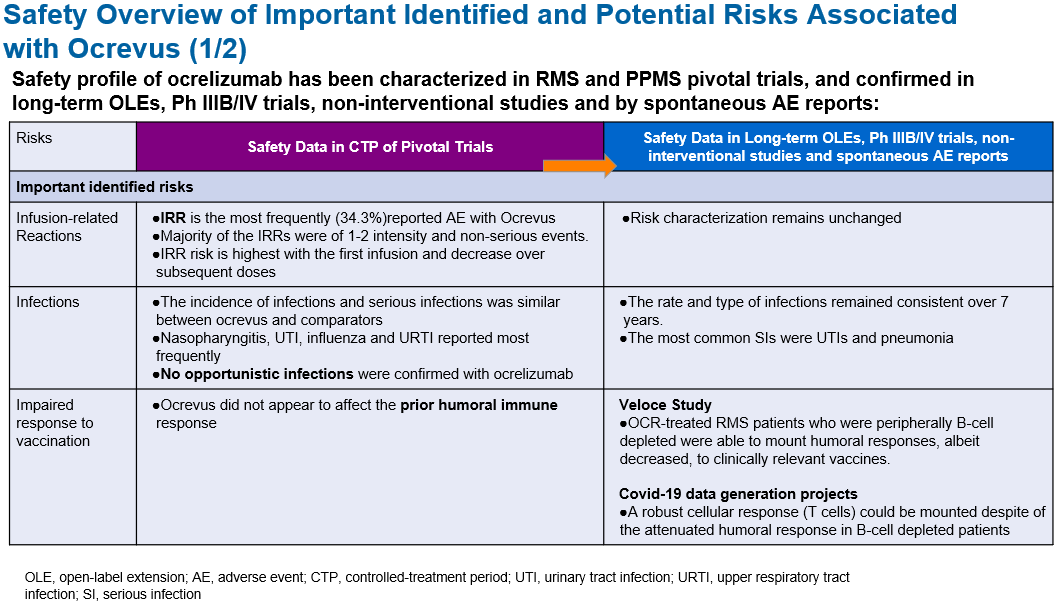

In [55]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [8]:
result, relevant_images = answer("symptoms of multiple sclerosis?")
print(result)

c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 Multiple Sclerosis (MS) is an autoimmune disease that affects the central nervous system, leading to various symptoms. The common symptoms of MS include:

1. Fatigue: Extreme tiredness, both physical and mental.
2. Muscle weakness: Difficulty moving muscles or maintaining a position.
3. Numbness/tingling: Sensations of pins and needles or loss of feeling in different parts of the body.
4. Balance problems and coordination difficulties: Issues with maintaining balance, walking, and performing fine motor tasks.
5. Muscle spasms: Involuntary muscle contractions.
6. Nerve pain: Pain caused by damage to nerves.
7. Vision changes: Optic neuritis or other vision disturbances.
8. Dizziness or vertigo: Feeling lightheaded, unsteady, or experiencing spinning sensations.

Secondary symptoms of MS can include:

1. Visual disturbances: Double vision, blurred vision, or other visual problems.
2. Urinary issues: Frequent urination, incontinence, or difficulty emptying the bladder.
3. Constipation: D

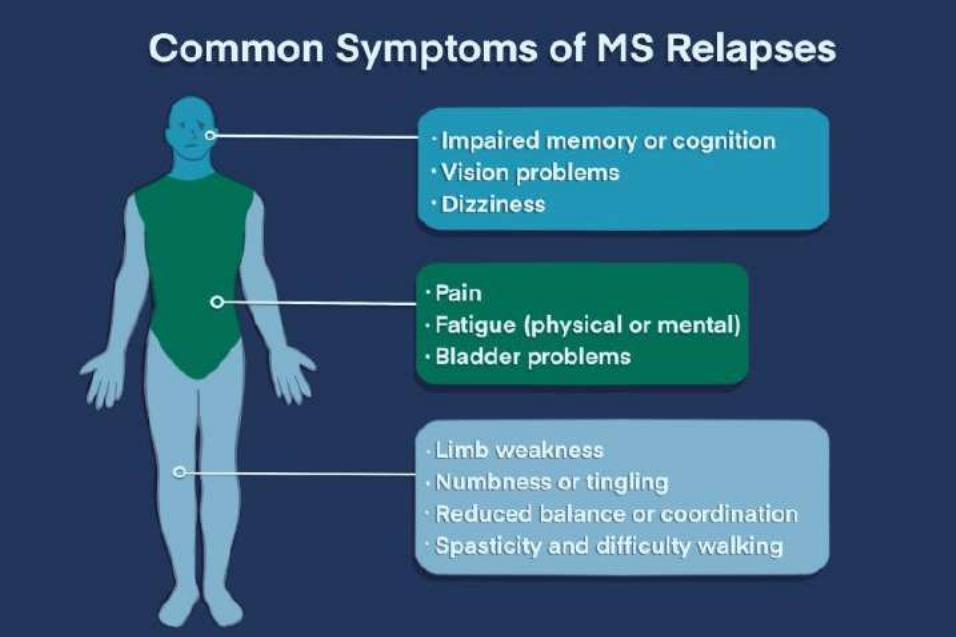

In [9]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [10]:
result, relevant_images = answer("what is an escalation therapy?")
print(result)

 An escalation therapy is a treatment strategy in multiple sclerosis (MS) where patients start with less aggressive therapies and then gradually progress to more potent treatments based on the complexity of their disease and the need for more effective interventions. The rationale behind this approach is to minimize potential negative effects, such as increased risk of severe adverse events or rapid progression, by starting with lower risk treatments. As the disease progresses or becomes more complex, patients may move onto more aggressive therapies to address the increasing symptoms and disability. This approach allows for a personalized treatment plan tailored to each patient's unique needs and disease course. However, it is essential to consider various factors like patient age, disease severity, presence of comorbid conditions, effectiveness, safety, and tolerability when selecting therapies for MS patients.


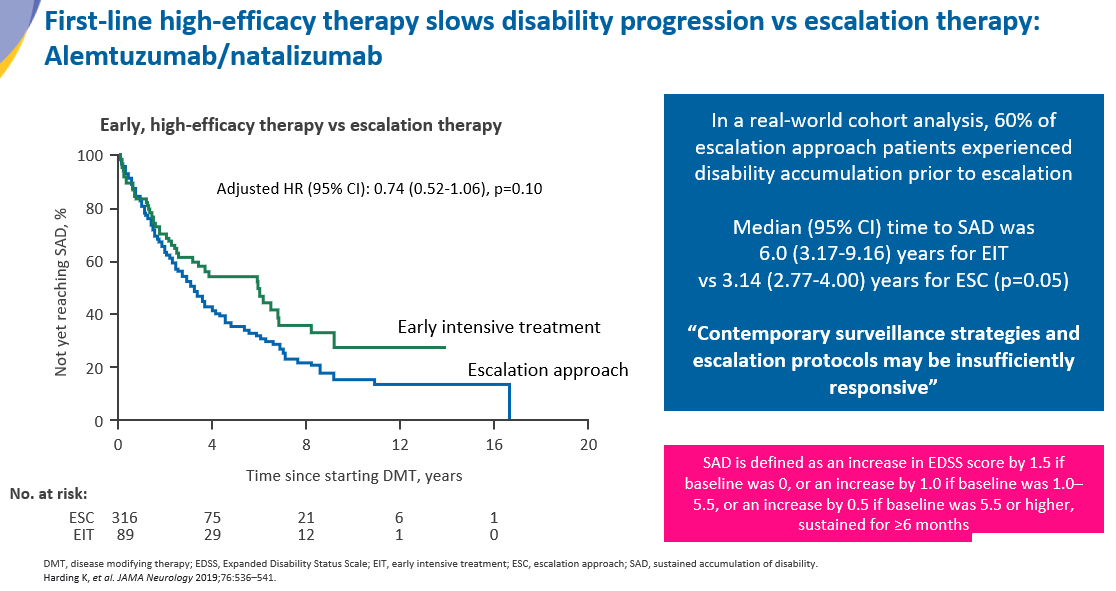

In [11]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [12]:
result, relevant_images = answer("what is the treatment for relapcing onset ms with active phenotype")
print(result)

 Based on the context provided in the image, the treatment for relapsing-onset MS with an active phenotype typically involves the use of corticosteroids, intravenous immunoglobulins (IVIG), or plasmapheresis to manage acute relapses. Corticosteroids are a class of drugs that suppress the immune system and reduce inflammation. IVIG is a preparation of antibodies from human plasma, which can help to reduce the severity of symptoms. Plasmapheresis is a procedure in which blood components are removed and replaced with donated plasma. These treatments aim to manage the symptoms of an MS relapse and provide some degree of disease activity control. However, it's important to note that these treatments do not modify the underlying course of the disease. The decision to use any of these treatments depends on various factors, including the severity and frequency of relapses, the patient's overall health status, and other individual considerations.


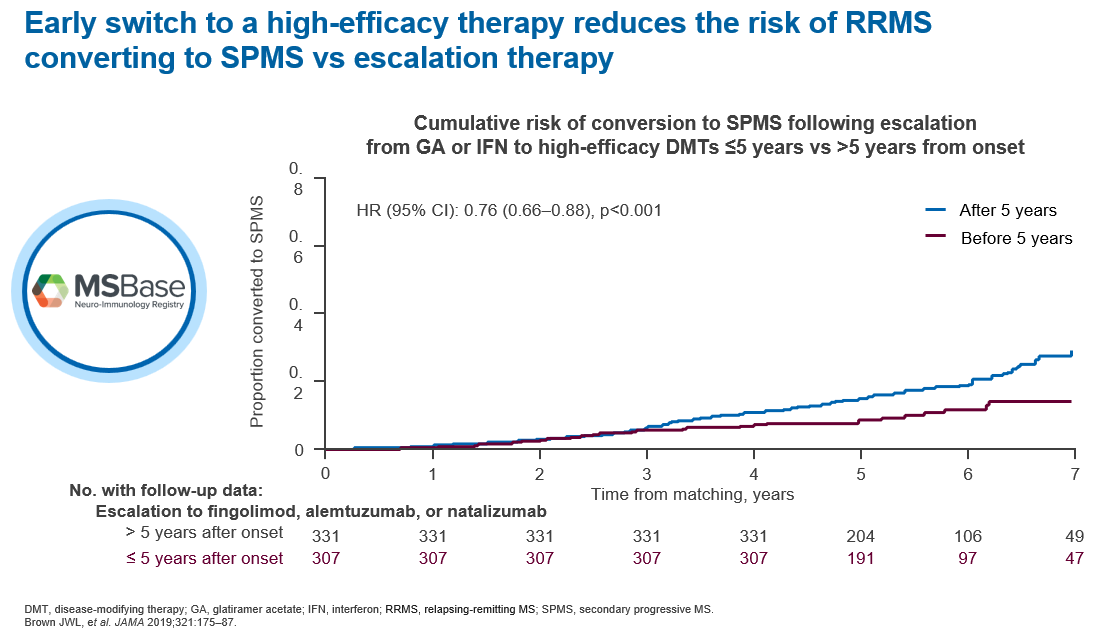

In [13]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [15]:
result, relevant_images = answer("tell me the patient eligibility criteria for oratorio ")
print(result)

 Based on the context provided in the image, the ORATORIO clinical trial has specific eligibility criteria for participants. The inclusion criteria are:

1. Age and Gender: Participants must be aged 18-65 years old.
2. Essential Steering Committee (ESS) score of 0 or 1.
3. A confirmed diagnosis of relapsing remitting multiple sclerosis (RRMS) by a central review committee.
4. Previous disease-modifying treatment (DMT) is not required, but participants should have received one or more DMTs for at least 6 months and then discontinued.
5. Disease activity score of 0 or 1 according to the 2017 MSIS-SPONSE criteria.

There are exclusion criteria mentioned in the image as well, but they were not visible in the provided section. The study included a significant number of patients, with a total of 107 participants enrolled. For more detailed information about the study results and patient characteristics, please refer to the "RESULTS" section of the document.


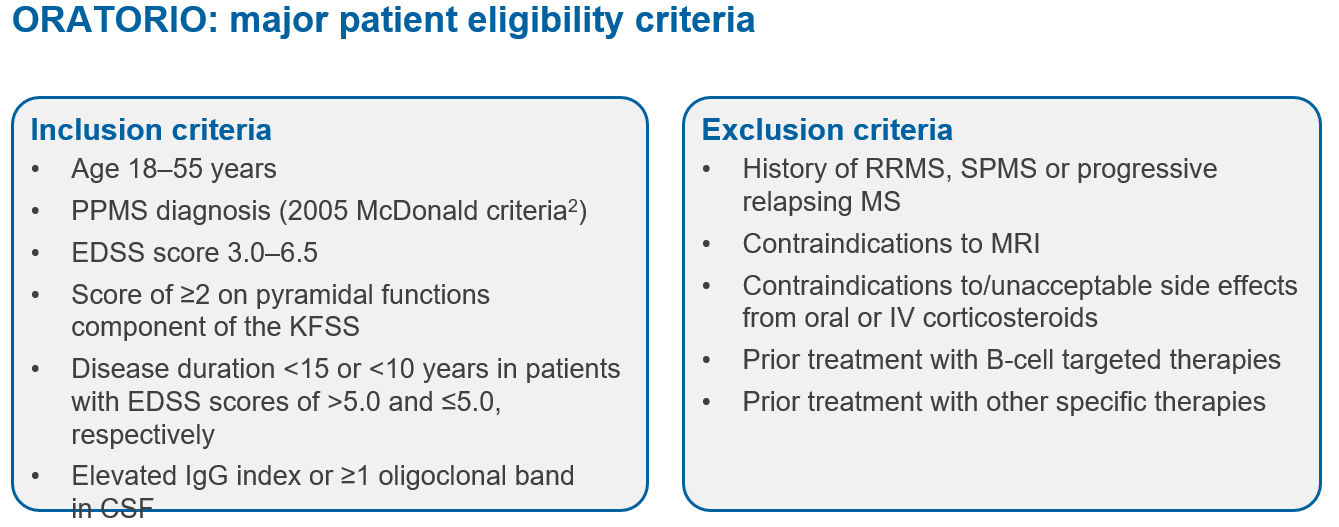

In [16]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [17]:
result, relevant_images = answer("what is the role of mri")
print(result)

 The role of MRI (Magnetic Resonance Imaging) in multiple sclerosis is significant for diagnosis, monitoring disease progression, and early detection. The slide title "Role of MRI" indicates this topic. The main body of the slide contains three bullet points detailing these aspects:

1. **Diagnosis**: While the diagnosis of multiple sclerosis is based on history and physical findings, MRI plays a crucial role in confirming the diagnosis by detecting lesions (areas of damage) in the brain and spinal cord. However, diagnostic criteria for MS are not always definitive, leading to potential misdiagnoses or incorrect diagnoses.
2. **Monitoring disease progression**: MRI is used to monitor the progression of multiple sclerosis over time by detecting new lesions and changes in existing ones. This information helps healthcare professionals assess the effectiveness of treatments and adjust them accordingly.
3. **Early detection**: MRI can help in early detection of multiple sclerosis, especiall

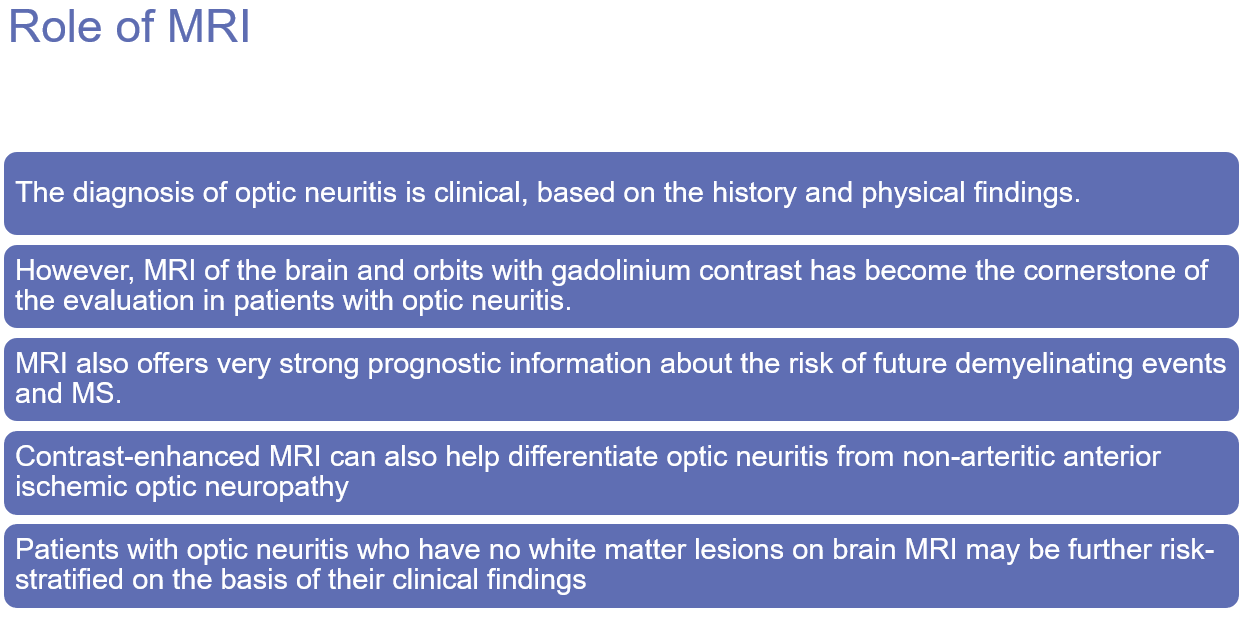

In [18]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [19]:
result, relevant_images = answer("ocreves pivotal trial outcome opera I & II in RMS pooled analysis")
print(result)

 The pivotal trial for Ocrevus in relapsing-remitting multiple sclerosis (RMS) is referred to as the "OPERA I & II" study. This double-blind, placebo-controlled trial involved 300 participants and evaluated the efficacy and safety of Ocrevus (likely a drug called cremizumab). The primary outcome measure for this study was the Annualized Relapse Rate (ARR).

The flowchart in the image illustrates an analysis process, starting with the primary endpoint of ARR. It then proceeds to various statistical analyses, such as "Change in 2dDSS" and "Change in total volume of cerebrospinal fluid." The change in cerebrospinal fluid volume from baseline week 12 to baseline week 8 is shown to be 58% for one group and 71% for another.

The text beneath the flowchart provides additional information about the Ocrevus trial, specifically mentioning a change in total volume of cerebrospinal fluid from baseline at different time points. This suggests that the study might have assessed changes in the amount 

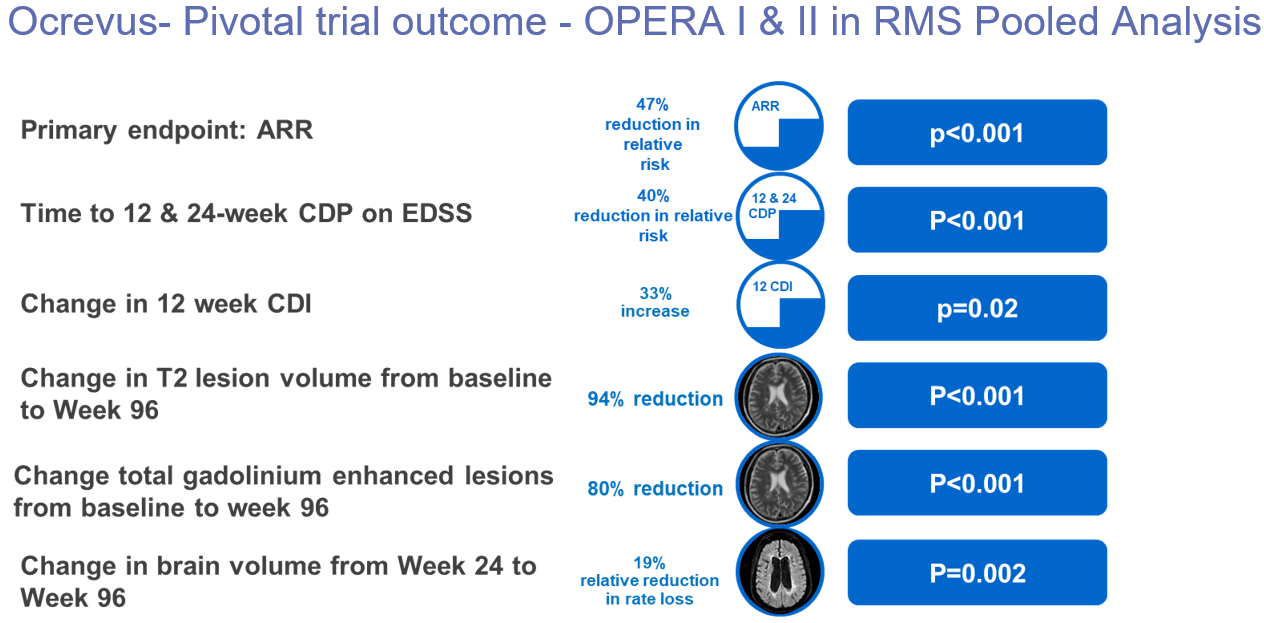

In [20]:
display.display(display.Image(base64.b64decode(relevant_images[0])))